In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=40aa684b60d1c33f0db13d0f99770679306ac9adf58ff2c02fb4c90238c4670b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=4c084873e505f719429287da813bebecbfd0300fff899a6b69721a4ec7a0921c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets,models,transforms,utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

import albumentations as A
from albumentations.pytorch import ToTensorV2


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
import os
root_dir='/content/drive/MyDrive/ADE'
images_dir=f"{root_dir}/images"
annotations_dir=f"{root_dir}/annotations"

In [5]:
images_training_dir = f"{images_dir}/training"
annotations_training_dir =  f"{annotations_dir}/training"

images_validation_dir = f"{images_dir}/validation"
annotations_validation_dir = f"{annotations_dir}/validation"

training_images = sorted(os.listdir(images_training_dir))
print(len(training_images))

training_annotations = sorted(os.listdir(annotations_training_dir))
print(len(training_annotations))

800
800


In [6]:
print(training_images[:5])
print(training_annotations[:5])

['ADE_train_00000001.jpg', 'ADE_train_00000002.jpg', 'ADE_train_00000003.jpg', 'ADE_train_00000004.jpg', 'ADE_train_00000005.jpg']
['ADE_train_00000001.png', 'ADE_train_00000002.png', 'ADE_train_00000003.png', 'ADE_train_00000004.png', 'ADE_train_00000005.png']


In [7]:
# # Preprocess images outside of training loop (just once)
# from PIL import Image
# import os

# def preprocess_images(input_dir, output_dir, size=(128, 128)):
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
#     for img_file in os.listdir(input_dir):
#         img_path = os.path.join(input_dir, img_file)
#         img = Image.open(img_path)
#         img = img.resize(size)
#         img.save(os.path.join(output_dir, img_file))

preprocessed_train_dir=f"{root_dir}/preprocessed_images"
preprocessed_val_dir=f"{root_dir}/preprocessed_val"
# preprocess_images(images_training_dir, preprocessed_train_dir)
# preprocess_images(images_validation_dir, preprocessed_val_dir)


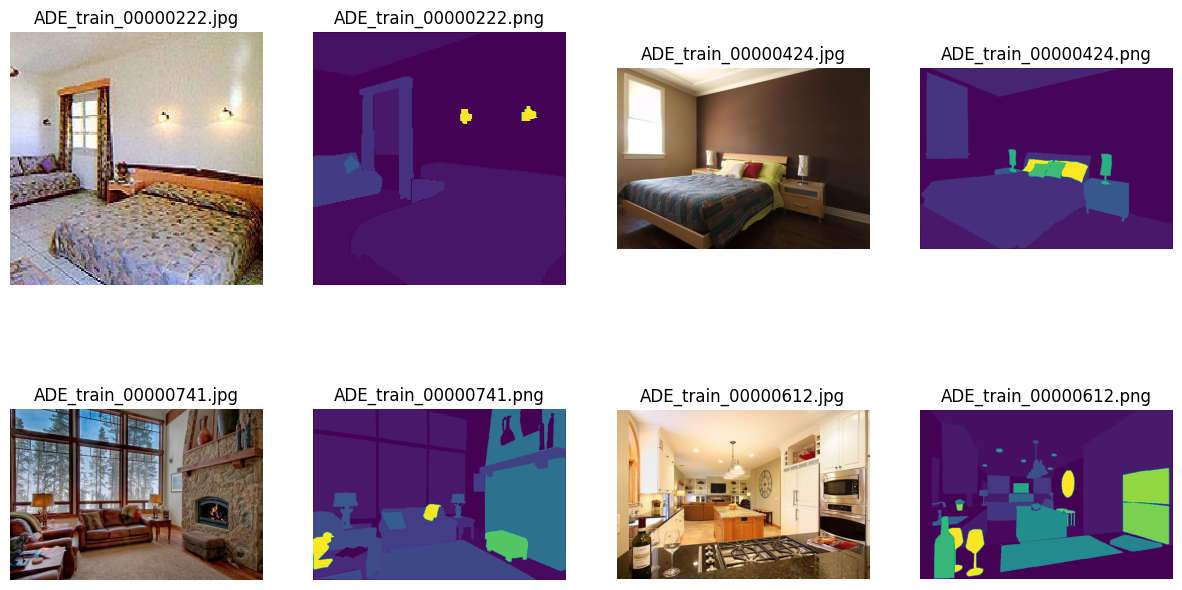

In [8]:
import numpy as np
import matplotlib.pyplot as plt
show_imgs=4
idx=np.random.choice(len(training_images),show_imgs,replace=False)
fig,axes=plt.subplots(show_imgs*2//4,4,figsize=(15,8))
axes=axes.flatten()
for i,ax in enumerate(axes):
  new_i=i//2
  if i%2==0:
    full_path=os.path.join(root_dir,"images/training/",training_images[idx[new_i]])
  else:
    full_path=os.path.join(root_dir,"annotations/training/",training_annotations[idx[new_i]])
  ax.imshow(plt.imread(full_path))
  basename=os.path.basename(full_path)
  ax.set_title(basename)
  ax.set_axis_off()

In [9]:
txt_path=f"{root_dir}/sceneCategories.txt"
with open(txt_path) as f:
  scene_categories=f.read().splitlines()
  classes=[values.split(" ")[-1] for values in scene_categories]
  classes=list(set(classes))
num_classes=len(classes)

In [10]:
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image

class ADEDataset(Dataset):
  def __init__(self,images_dir,annotations_dir, transform_image=None, transform_mask=None):
    self.images_dir=images_dir
    self.annotations_dir=annotations_dir
    self.transform_image=transform_image
    self.transform_mask=transform_mask
    self.images_files=sorted(os.listdir(images_dir))
    self.mask_files=sorted(os.listdir(annotations_dir))

  def __len__(self):
    return len(self.images_files)

  def __getitem__(self,idx):
    image_filename=self.images_files[idx]
    img_name = os.path.join(self.images_dir, image_filename)
    image = Image.open(img_name).convert("RGB")
    mask_filename = image_filename.replace(".jpg", ".png")
    mask_name = os.path.join(self.annotations_dir, mask_filename)
    mask = Image.open(mask_name)
    if self.transform_image:
        image = self.transform_image(image)
    if self.transform_mask:
        mask = self.transform_mask(mask)
    mask=mask.long()
    return image, mask



In [11]:


transform_image = transforms.Compose([

    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long)) # Ensure it's cast to a long tensor
])

In [12]:
train_dataset=ADEDataset(preprocessed_train_dir,annotations_training_dir,transform_image=transform_image,transform_mask=transform_mask)
val_dataset=ADEDataset(preprocessed_val_dir,annotations_validation_dir,transform_image=transform_image,transform_mask=transform_mask)

In [13]:
train_loader=DataLoader(train_dataset,batch_size=1,shuffle=True,num_workers=4, pin_memory=True)
val_loader=DataLoader(val_dataset,batch_size=1,shuffle=False,num_workers=4, pin_memory=True)

In [14]:
import torch
# device=torch.device("cpu")

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:

model=smp.Unet(encoder_name="resnet18",
               encoder_weights="imagenet",
               in_channels=3,
               classes=num_classes,
               )

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 245MB/s]


In [16]:
for i, (image, mask) in enumerate(train_loader):
    print(f"Batch {i+1}: Image shape: {image.shape}, Mask shape: {mask.shape}")
    if i == 5:
        break


Batch 1: Image shape: torch.Size([1, 3, 128, 128]), Mask shape: torch.Size([1, 128, 128])
Batch 2: Image shape: torch.Size([1, 3, 128, 128]), Mask shape: torch.Size([1, 128, 128])
Batch 3: Image shape: torch.Size([1, 3, 128, 128]), Mask shape: torch.Size([1, 128, 128])
Batch 4: Image shape: torch.Size([1, 3, 128, 128]), Mask shape: torch.Size([1, 128, 128])
Batch 5: Image shape: torch.Size([1, 3, 128, 128]), Mask shape: torch.Size([1, 128, 128])
Batch 6: Image shape: torch.Size([1, 3, 128, 128]), Mask shape: torch.Size([1, 128, 128])


In [27]:
def train(dataloader,model,loss_fn,optimizer,lr_scheduler,device):
  size=len(dataloader.dataset)
  num_batches=len(dataloader)
  model.train()
  epoch_loss=0
  epoch_iou_score=0
  for batch_i,(x, y) in enumerate(dataloader):
    # print(f"Processing batch {batch_i+1}/{num_batches}...")
    x,y=x.to(device),y.to(device)
    optimizer.zero_grad()
    pred=model(x)
    loss=loss_fn(pred,y)

    loss.backward()
    optimizer.step()

    epoch_loss+=loss.item()
    y=y.round().long()
    pred=torch.argmax(pred,dim=1)
    tp,fp,fn,tn=smp.metrics.get_stats(pred,y,mode="multiclass",num_classes=num_classes)
    iou_score=smp.metrics.iou_score(tp,fp,fn,tn,reduction="micro").item()
    epoch_iou_score+=iou_score
  lr_scheduler.step()
  return epoch_loss/num_batches,epoch_iou_score/num_batches

In [28]:
def test(dataloader,model,loss_fn,device):
  size=len(dataloader.dataset)
  num_batches=len(dataloader)
  model.eval()
  epoch_loss=0
  epoch_iou_score=0
  with torch.no_grad():
    for batch_i,(x, y) in enumerate(dataloader):
      x,y=x.to(device),y.to(device)
      pred=model(x)
      loss=loss_fn(pred,y)
      epoch_loss+=loss.item()
      y=y.round().long()
      pred=torch.argmax(pred,dim=1)
      tp,fp,fn,tn=smp.metrics.get_stats(pred,y,mode="multiclass",num_classes=num_classes)
      iou_score=smp.metrics.iou_score(tp,fp,fn,tn,reduction="micro").item()

      epoch_iou_score+=iou_score
  return epoch_loss/num_batches,epoch_iou_score/num_batches

In [33]:
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
# device=torch.device("cpu")
device=torch.device('cuda' if torch.cuda.is_available else "cpu")
EPOCHS=100
logs={
    'train_loss':[],'val_loss':[],
    'train_iou_score':[],'val_iou_score':[],
}
if not os.path.exists(f'{root_dir}/checkpoints'):
  os.makedirs(f'{root_dir}/checkpoints')

loss_fn=smp.losses.DiceLoss(mode="multiclass")

learning_rate=0.0001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
step_lr_scheduler=lr_scheduler.StepLR(optimizer,step_size=2000,gamma=0.1)
patience=5
counter=0
best_loss=np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
  train_loss,train_iou_score=train(train_loader,model,loss_fn,optimizer,step_lr_scheduler,device)
  val_loss,val_iou_score=test(val_loader,model,loss_fn,device)
  logs['train_loss'].append(train_loss)
  logs['val_loss'].append(val_loss)
  logs['train_iou_score'].append(train_iou_score)
  logs['val_iou_score'].append(val_iou_score)

  print(f'EPOCH: {str(epoch+1).zfill(3)} \
  train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
  train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
  lr: {optimizer.param_groups[0]["lr"]}')
  torch.save(model.state_dict(),f"{root_dir}/checkpoints/last.pth")

  if val_loss<best_loss:
    counter=0

    best_loss=val_loss
    torch.save(model.state_dict(),f"{root_dir}/checkpoints/best.pth")
  else:
    counter+=1

  if counter>=patience:
    print("Early stopping")
    break

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH: 001   train_loss: 0.0809, val_loss: 0.0715   train_iou_score: 0.432, val_iou_score: 0.218   lr: 0.0001


  2%|▏         | 2/100 [01:03<51:59, 31.84s/it]

EPOCH: 002   train_loss: 0.0808, val_loss: 0.0717   train_iou_score: 0.434, val_iou_score: 0.198   lr: 0.0001
EPOCH: 003   train_loss: 0.0806, val_loss: 0.0715   train_iou_score: 0.438, val_iou_score: 0.216   lr: 0.0001


  4%|▍         | 4/100 [02:07<50:46, 31.73s/it]

EPOCH: 004   train_loss: 0.0805, val_loss: 0.0715   train_iou_score: 0.441, val_iou_score: 0.223   lr: 0.0001


  5%|▌         | 5/100 [02:38<50:00, 31.58s/it]

EPOCH: 005   train_loss: 0.0804, val_loss: 0.0716   train_iou_score: 0.444, val_iou_score: 0.213   lr: 0.0001


  6%|▌         | 6/100 [03:10<49:31, 31.61s/it]

EPOCH: 006   train_loss: 0.0803, val_loss: 0.0715   train_iou_score: 0.446, val_iou_score: 0.226   lr: 0.0001


  7%|▋         | 7/100 [03:41<48:51, 31.52s/it]

EPOCH: 007   train_loss: 0.0802, val_loss: 0.0717   train_iou_score: 0.449, val_iou_score: 0.190   lr: 0.0001


  7%|▋         | 7/100 [04:12<55:59, 36.12s/it]

EPOCH: 008   train_loss: 0.0802, val_loss: 0.0715   train_iou_score: 0.449, val_iou_score: 0.222   lr: 0.0001
Early stopping


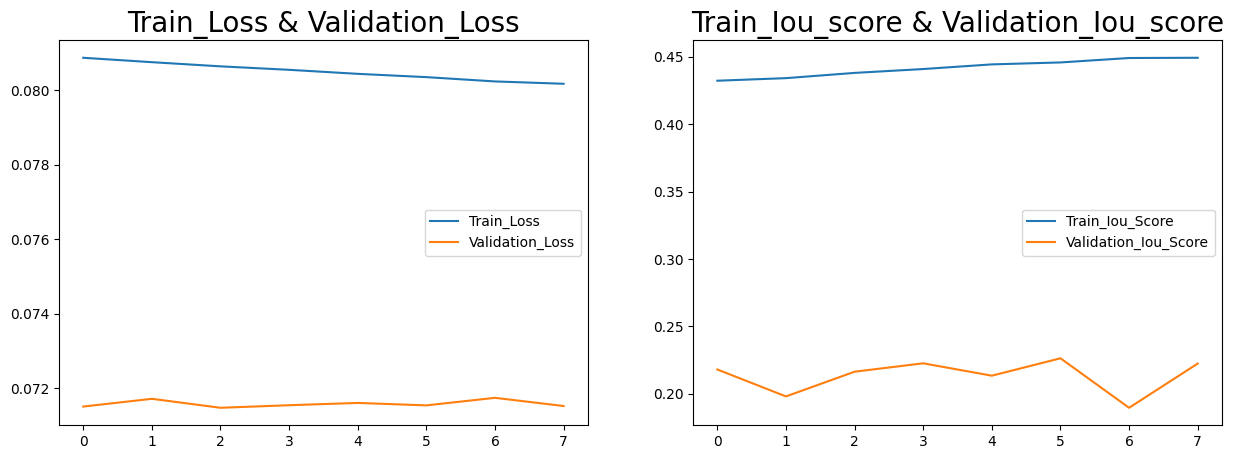

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()

In [35]:
test_dataset = ADEDataset(preprocessed_val_dir,annotations_validation_dir, transform_image=transform_image,transform_mask=transform_mask)

<ipython-input-36-a8c077bb8b26>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{root_dir}/checkpoints/best.pth"))


torch.Size([3, 128, 128]) torch.Size([128, 128])


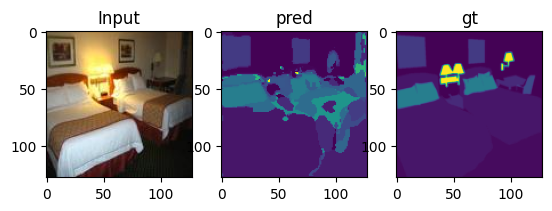

torch.Size([3, 128, 128]) torch.Size([128, 128])


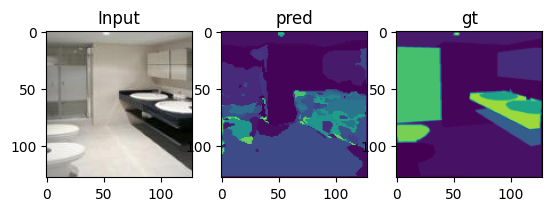

torch.Size([3, 128, 128]) torch.Size([128, 128])


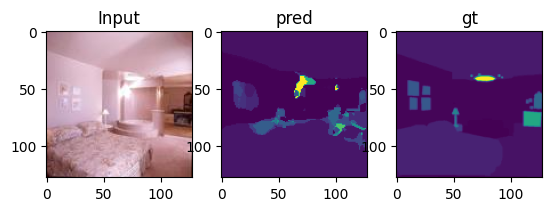

torch.Size([3, 128, 128]) torch.Size([128, 128])


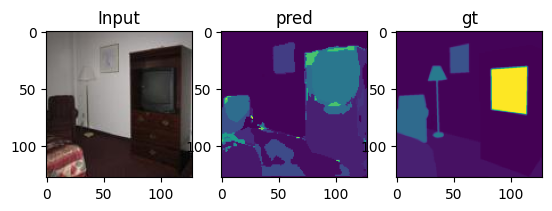

In [36]:
model.load_state_dict(torch.load(f"{root_dir}/checkpoints/best.pth"))
model.to(device)
show_imgs = 4
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)
for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]

    image, mask = sample
    print(image.shape, mask.shape)
    pred = model(image.to(device, dtype=torch.float32).unsqueeze(0))
    pred = torch.argmax(pred,dim=1).squeeze(0)
    pred = pred.data.cpu().numpy()
    # print(f'pred_2.shape: {pred.shape}')
    pred_view = Image.fromarray(np.uint8(pred), 'L')

    img_view = Image.fromarray(np.uint8(image.permute(1, 2, 0).cpu().numpy() * 255), 'RGB')
    mask_view = Image.fromarray(np.uint8(mask.cpu().numpy()), 'L')
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(pred_view)
    axarr[1].set_title('pred')
    axarr[2].imshow(mask_view)
    axarr[2].set_title('gt')
    plt.show()